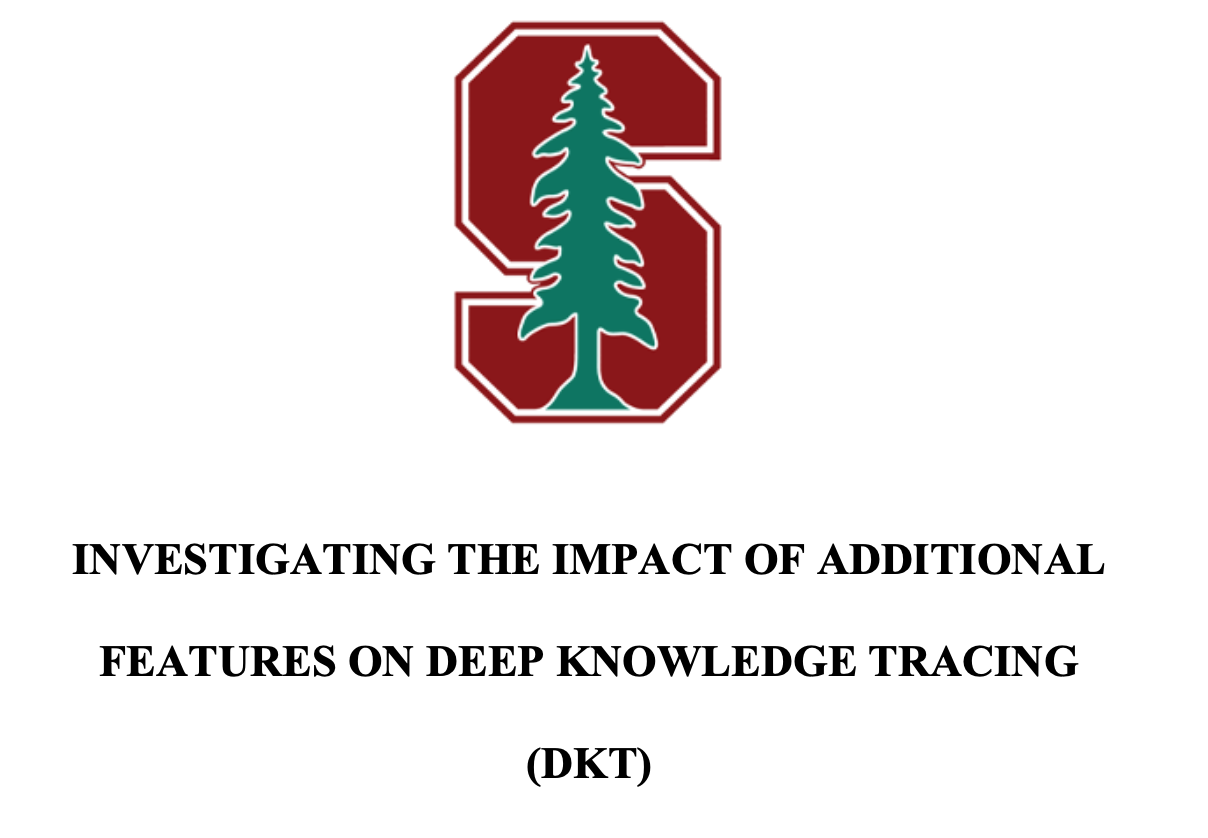

**Student : Othman Bensouda Koraichi**

# Table of contents
1. [Introduction](#introduction)
    1. [Problem](#Problem)
    2. [Research questions](#rq)
2. [Libraries](#libraries)
3. [Data](#data)
    1. [Dataset](#dataset)
    2. [Data dictionary](#datadic)
    3.[Data cleaning (general)](#datacleaning)
        1. [Misalignments](#misalignments)
        2. [Duplicates](#duplicates)
        3. [Unnecessary columns](#unnecessary)
        4. [Clean names](#cleannames)
        5. [Data type](#datatype)
3. [Training and testing sets](#ttv)  
4. [Bayesian Knowledge Tracing](#bkt)
    1. [Library for BKT](#librarybkt)
    2. [Data cleaning (specific to BKT)](#cleanbkt)
        3. [Change column names to fit with the library](#changecolnamebkt)
        4. [Convert dataframe to csv](#convdatatocsv)
    3. [BKT Model](#modelbkt)
    4. [Results](#resultbkt)
5. [Deep Knowledge Tracing](#dkt)
    1. [Data cleaning (specific to neural networks)](#datacleandkt)
        1. [Create sequences of data for each user](#sequencesdkt)
        2. [Normalize categorical variables](#catvardkt)
        3. [Normalize numeric variables](#numvardkt)
    2. [DKT Model](#modeldkt)
        
6. [References](#references)


# Introduction <a name="introduction"></a>

## Problem <a name="Problem"></a>

Student knowledge measurement is central in learning environments to provide feedback, evaluate educational programs, set goals and make learning-oriented decisions. This task is inherently difficult as human learning is grounded in the complexity of both the human brain and human knowledge. Thus, the use of complex models seems appropriate. Nevertheless, previous work mainly relies on Hidden Markov models containing several statistical problems. Knowledge tracing is the task of modeling student knowledge over time so that it can be predicted how students will perform on future interactions. Each time the student answers an exercise, a prediction is made as to whether or not they would answer an exercise of each type correctly on their next interaction.
Deep Knowledge Tracing (DKT) is a subset of Knowledge Tracing in which flexible recurrent neural networks (RNN) are applied for the task of modeling student knowledge. This method, first published by Chris Piech in 2015, has proved to outperform traditional knowledge tracing methods. However, RNNs were trained on datasets which only contained binary data about the correctness of answers (e.g whether a user correctly answered (1) or incorrectly answered (0) a question). The latest available literature suggested incorporating several new features to further ameliorate the accuracy of the DKT algorithm.
Hence, the core of the project is to write a Deep Learning algorithm that predicts whether a student is going to answer a question correctly within a quiz. This task is important because it allows intelligent tutoring systems to calibrate the difficulty of the questions that they will show to students. If a student is shown too many questions that they can’t answer, the student will become frustrated, and will stop learning. If a student is shown too many questions that they can answer easily, the student will become uninterested, and will stop learning.
While we find replicating Chris Piech’s work with our own data interesting, we also want to investigate whether adding other inputs, such as time to answer, skill, sub-skill etc. would further improve the accuracy of the DKT algorithm.


## Research questions <a name="rq"></a>

**In this project, we will** :

● Explore whether Deep Knowledge Tracing generalizes well. In other words, we will test whether DKT still performs better than BKT on a different dataset than the ones initially used in Chris Piech’s project.

● Explore whether new inputs, such as time to answer, skill, sub-skill etc. can improve the performance of DKT, as suggested by Chris Piech.

These answers are important because they can inform the companies that develop intelligent tutoring systems, about which algorithm they should use to better predict performance (BKT or DKT), and which data they need to collect in order to feed these algorithms.

# Libraries <a name="libraries"></a>

In [240]:
# Import libraries 
from IPython.display import display
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import os
import janitor
import numpy as np
from pyBKT.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Data <a name="data"></a>

## Dataset <a name="dataset"></a>


We test our ability to predict student performance on a dataset that we specifically got for this research, coming from Workera, a platform that offers adaptive assessments on specific areas of knowledge useful for Data Science related positions.
The uniqueness of this dataset not only allows us to reproduce and test previous work, but also to incorporate new inputs which have not been analyzed by other researchers to the best of our knowledge.



In [ ]:
# We read the data
data = pd.read_csv('/Users/mydodethailung/Desktop/EDS seminar/EDS project/report-from-2021-08.csv',error_bad_lines=False)

In [ ]:
# We observe the first 5 rows
data.head(5)

In [ ]:
# We observe the shape of the data. 7.5M rows and 12 variables.
data.shape

## Data dictionary <a name="datadic"></a>


The following dataframe summarizes the different variables and their description.

In [ ]:
# Display data dictionary
data_dic = pd.read_excel('/Users/mydodethailung/Desktop/data dic.xlsx')
pd.set_option('max_colwidth', 400)
data_dic

## Data Cleaning (general) <a name="datacleaning"></a>

### Misalignments <a name="misalignments"></a>


There were misalignments of columns in the raw dataset and we had to delete all the rows having information that did not match with the column name (approximately 20K rows out of 1.2M rows). In this picture, we notice that the 'Date' column does not contain dates but rather skills, and the 'Attempt' column contains dates instead.

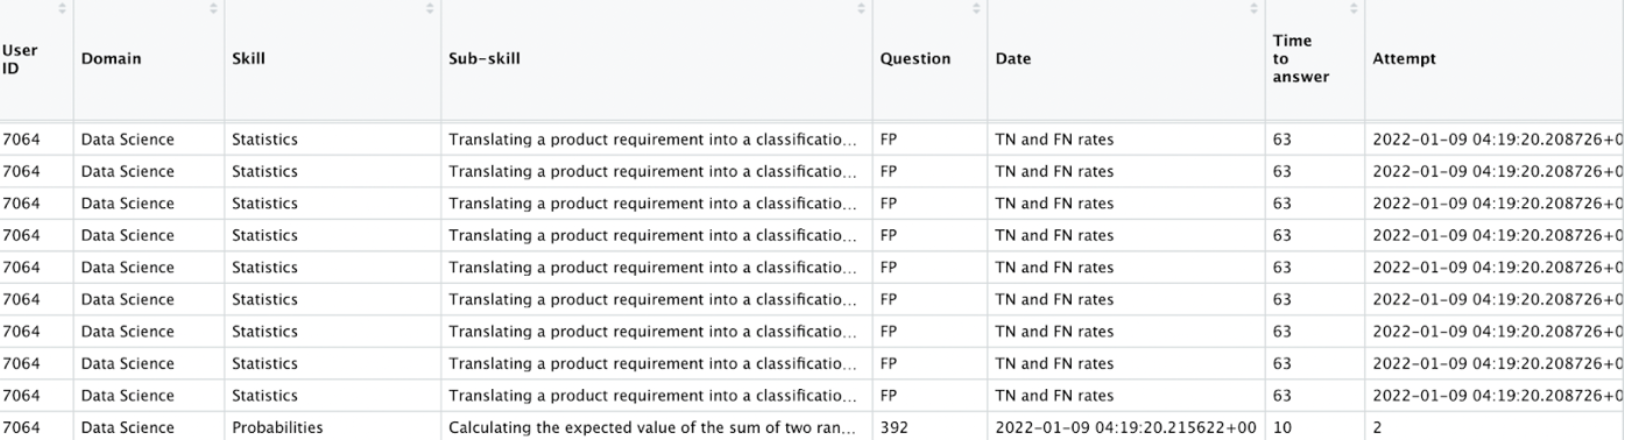

In [ ]:
def clean_misalignments(dataset_name): 
    with open(f"{dataset_name}.csv", "r") as f: 
        txt = f.read()
    txt = txt.replace("idempotency\n", "idempotency")
    
    # problem in the data is that "sub-skill"
    # has names with "," in it 
    txt_ls = txt.split("\n")
    txt_set = set([t.rsplit(",", 8)[0] for t in txt_ls])
    txt_set = set([t.split(",", 3)[-1] for t in txt_set])
    problematic = [t for t in txt_set if t.count(",")>0]
    
    print("solving problems for problematic cases: ")
    display(problematic) 
    for passage in problematic: 
        txt = txt.replace(passage, passage.replace(",", "$"))
        
    with open(f"{dataset_name}_cleaned.csv", "w") as f: 
        f.write(txt)

In [ ]:
# We apply the function
clean_misalignments('/Users/mydodethailung/Desktop/EDS seminar/EDS project/report-from-2021-08')

In [246]:
# We read the cleaned dataset
data = pd.read_csv('/Users/mydodethailung/Desktop/EDS seminar/EDS project/report-from-2021-08_cleaned.csv')

### Duplicates <a name="duplicates"></a>

Looking at the raw data, we observed many duplicate rows. From the initial 7.5 million rows, we ended up with 1.2 million rows, after removing all perfect duplicates

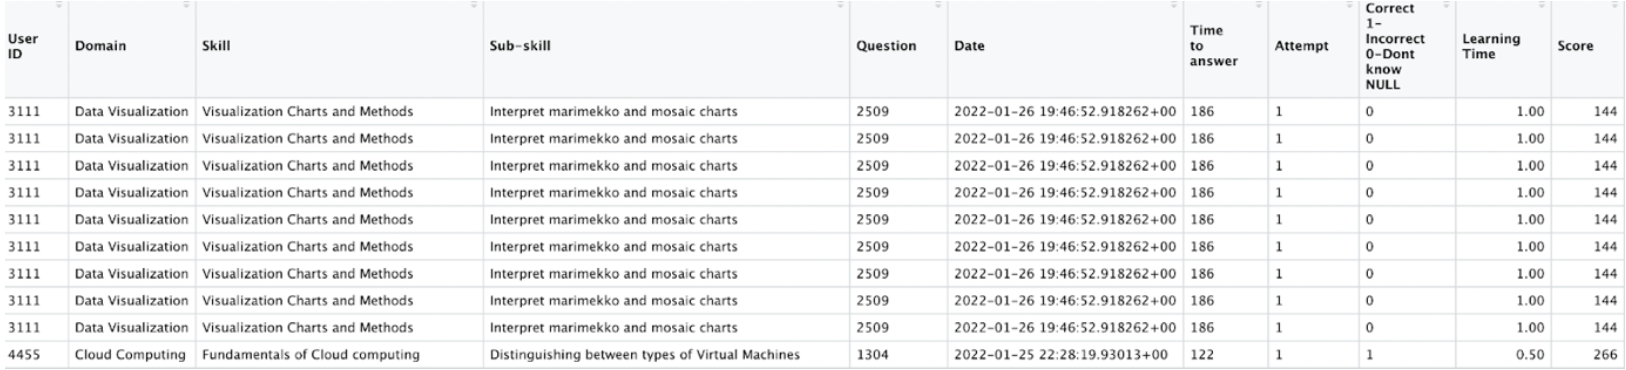

In [247]:
# We drop duplicates
data = data.drop_duplicates(ignore_index= True)
# We observe the new shape
data.shape

(1267132, 12)

### Unnecessary columns <a name="unnecessary"></a>

Some columns are unnecessary for the scope of this project. Thus, we will drop them.

In [248]:
# Remove unnecessary columns and duplicates
df_general = data.drop(['Learning Time','Score','Target Score'], axis = 1).reset_index(drop = True)

### Binarize the outcome  <a name="binary"></a>

Currently, the variable defining correctness of answers has 3 outcomes : 1 for a correct answer, 0 for an incorrect answer, and a null value if the user did not answer. For our project, we will binarize this variable and consider that no answer is equivalent to having a wrong answer because the student does not know the correct answer.

In [249]:
# For the "correct" column, consider that no answer is an incorrect answer
df_general['Correct 1-Incorrect 0-Dont know NULL'] = df_general['Correct 1-Incorrect 0-Dont know NULL'].fillna(0)

### Remove NA values <a name="navalues"></a>

We remove the NA values from the dataset.

In [250]:
df_general = df_general.dropna()

### Clean names <a name="cleannames"></a>

The names of our variables contain capital letters,spaces, and other symbols. We use the janitor function to simplify these names.

In [251]:
df_general = df_general.clean_names()
df_general.head(5)
# Rename the column representing correctness of answer
df_general.rename(columns = {'correct_1_incorrect_0_dont_know_null':'correct'}, inplace = True)


### Data type <a name="datatype"></a>

Some data types are not appropriate. We convert them to the right data types.

In [252]:
# Observe the data types
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254215 entries, 0 to 1267131
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1254215 non-null  float64
 1   domain          1254215 non-null  object 
 2   skill           1254215 non-null  object 
 3   sub_skill       1254215 non-null  object 
 4   question        1254215 non-null  int64  
 5   date            1254215 non-null  object 
 6   time_to_answer  1254215 non-null  int64  
 7   attempt         1254215 non-null  int64  
 8   correct         1254215 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 95.7+ MB


In [256]:
# Change the user ID and the correctness column to integers 
# Change date column to date
df_general["correct"] = df_general["correct"].astype(int)
df_general["date"] = pd.to_datetime(df_general["date"])
df_general["user_id"] = df_general["user_id"].astype(int)

In [257]:
df_general.head()

,user_id,domain,skill,sub_skill,question,date,time_to_answer,attempt,correct
0,3111,Data Visualization,Visualization Charts and Methods,Interpret marimekko and mosaic charts,2509,2022-01-26 19:46:52.918262+00:00,186,1,0
1,4455,Cloud Computing,Fundamentals of Cloud computing,Distinguishing between types of Virtual Machines,1304,2022-01-25 22:28:19.930130+00:00,122,1,1
2,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:05.659029+00:00,30,4,0
3,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:44.283979+00:00,30,4,0
4,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:55:54.462949+00:00,30,4,0


# Training and testing sets <a name="ttv"></a> 

Let us randomly choose the users that will be in the training, testing and validation sets of the BKT and the DKT models. Remember that each user has a sequence of questions, so we should not split the dataset by rows, but rather by users ! In other words, we should not choose 80% of rows as the training set, but 80% of users.

In [258]:
# We use scikit learn to split our dataset by groups (here, we want to choose 80% of users for the training set)
# For BKT, we will only have a training set and a testing set (80% 20%). 
# For DKT, the testing set will be split in 2 because we will also have a validation set.(80% 10% 10%)
splitter = sklearn.model_selection.GroupShuffleSplit(test_size=.20, random_state = 7)
split = splitter.split(df_general, groups=df_general['user_id'])
train_inds, test_inds = next(split)

train = df_general.iloc[train_inds]
test = df_general.iloc[test_inds]

In [259]:
# We check that our split makes sense
print("Number of training users : %f" %train.shape[0])
print("Number of testing users : %f" %test.shape[0])

Number of training users : 996636.000000
Number of testing users : 257579.000000


# Bayesian Knowledge Tracing <a name="bkt"></a>

In recent years, Corbett & Anderson’s Bayesian Knowledge Tracing model (BKT) has been used to model student knowledge in a variety of systems. BKT models a learner’s latent knowledge state as a set of binary variables, each of which represents understanding or non-understanding of a certain domain. A Hidden Markov Model (HMM) is used to update the probabilities across each of these binary variables, as a learner answers exercises of a given domain correctly or incorrectly.

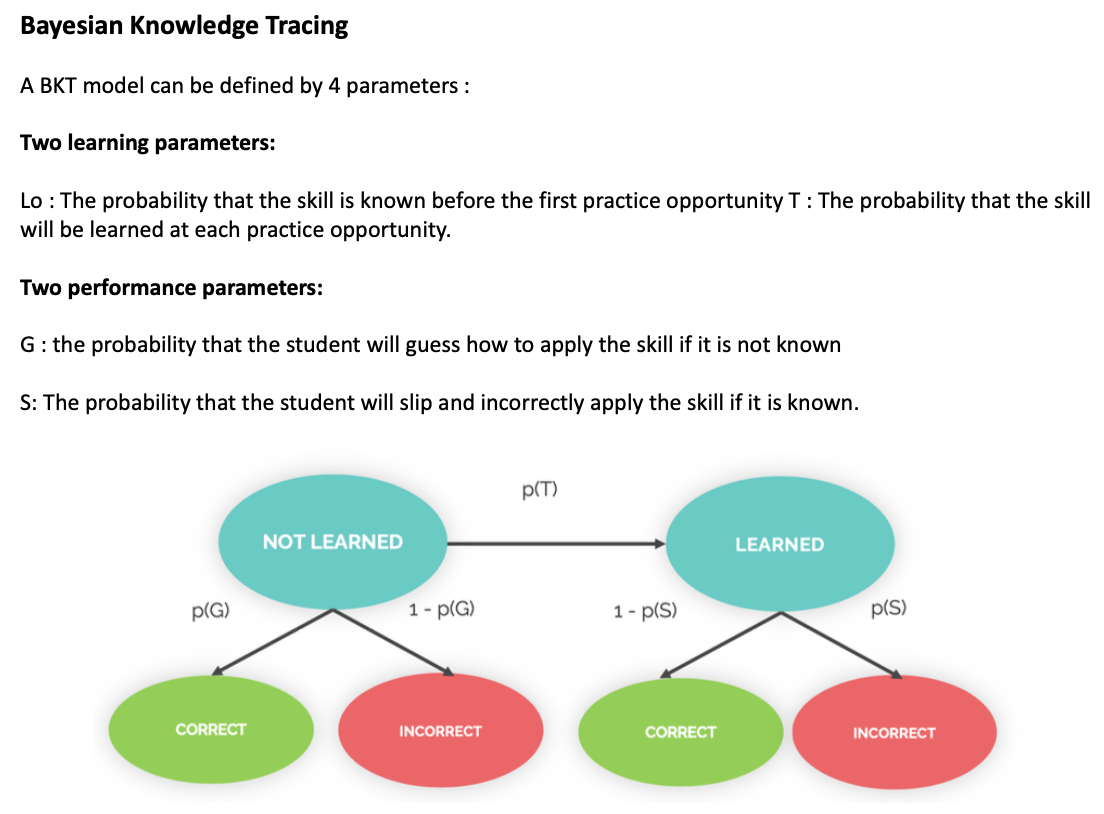

## Library for BKT <a name="librarybkt"></a>

We will use the pyBKT library, based on the work of Zachary A. Pardos (zp@berkeley.edu) and Matthew J. Johnson (mattjj@csail.mit.edu) @ https://github.com/CAHLR/xBKT

pyBKT models student mastery of a skills as they progress through series of learning resources and checks for understanding. Mastery is modelled as a latent variable has two states - "knowing" and "not knowing". At each checkpoint, students may be given a learning resource (i.e. watch a video) and/or question(s) to check for understanding. The model finds the probability of learning, forgetting, slipping and guessing that maximizes the likelihood of observed student responses to questions.

## Data cleaning (specific to BKT) <a name="cleanbkt"></a>

### Change column names to fit with the library <a name="changecolnamebkt"></a>

The pyBKT library requires that we change some of our column names.

In [183]:
# Rename the domain column, that we will consider as the skills in our models.
df_bkt = df_general.copy(deep=True)
df_bkt.rename(columns = {'domain':'skill_name'}, inplace = True)

In [13]:
df_bkt.head()

,user_id,skill_name,skill,sub_skill,question,date,time_to_answer,attempt,correct
0,"3,111.00000",Data Visualization,Visualization Charts and Methods,Interpret marimekko and mosaic charts,2509,2022-01-26 19:46:52.918262+00:00,186,1,0
1,"4,455.00000",Cloud Computing,Fundamentals of Cloud computing,Distinguishing between types of Virtual Machines,1304,2022-01-25 22:28:19.930130+00:00,122,1,1
2,"5,541.00000",Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:05.659029+00:00,30,4,0
3,"5,541.00000",Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:44.283979+00:00,30,4,0
4,"5,541.00000",Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:55:54.462949+00:00,30,4,0


### Convert dataframe to csv <a name="convdatatocsv"></a>

The library requires a csv file as an input. We thus convert our dataframe to a csv file.

In [212]:
# Change dataframe to csv
df_bkt.iloc[train_inds].to_csv('df_bkt_train.csv')
df_bkt.iloc[test_inds].to_csv('df_bkt_test.csv')

In [207]:
df_bkt.iloc[train_inds]

,user_id,skill_name,skill,sub_skill,question,date,time_to_answer,attempt,correct
0,3111,Data Visualization,Visualization Charts and Methods,Interpret marimekko and mosaic charts,2509,2022-01-26 19:46:52.918262+00:00,186,1,0
1,4455,Cloud Computing,Fundamentals of Cloud computing,Distinguishing between types of Virtual Machines,1304,2022-01-25 22:28:19.930130+00:00,122,1,1
2,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:05.659029+00:00,30,4,0
3,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:54:44.283979+00:00,30,4,0
4,5541,Machine Learning,Understanding methods to train ML models,Differentiating stochastic from batch gradient...,40,2022-01-16 18:55:54.462949+00:00,30,4,0
...,...,...,...,...,...,...,...,...,...
1267127,146824,Machine Learning,Structuring machine learning projects,Choosing the right dataset split between train...,37,2021-10-12 13:54:56.751459+00:00,61,1,0
1267128,150363,Machine Learning,Structuring machine learning projects,Choosing the right dataset split between train...,37,2021-12-13 23:17:26.577058+00:00,57,1,0
1267129,53797,Data Science,Probabilities,Computing the probability of a series of n ind...,387,2021-08-16 19:30:22.583726+00:00,16,1,1
1267130,53797,Data Science,Probabilities,Computing the probability of a series of n ind...,387,2021-08-16 19:30:22.583726+00:00,16,1,1


In [208]:
df_bkt.iloc[test_inds]

,user_id,skill_name,skill,sub_skill,question,date,time_to_answer,attempt,correct
152,34016,Python,Python functions,Create arbitrary arguments using **kwargs,1173,2022-01-05 22:15:12.959252+00:00,45,1,0
170,38702,Data Structures & Algorithms,Data Structures,Understanding multidimensional array,1303,2022-01-27 01:36:13.210214+00:00,113,1,0
171,38702,Data Structures & Algorithms,Data Structures,Understanding multidimensional array,1303,2022-01-27 01:33:30.328647+00:00,113,1,0
172,38702,Data Structures & Algorithms,Data Structures,Understanding multidimensional array,1303,2022-01-27 01:33:59.600008+00:00,113,1,0
173,38702,Data Structures & Algorithms,Data Structures,Understanding multidimensional array,1303,2022-01-27 01:35:22.399387+00:00,113,1,0
...,...,...,...,...,...,...,...,...,...
1267095,146888,Machine Learning,Understanding methods to train ML models,Quantifying the penalty due to L2 regularization,74,2021-10-22 07:35:02.861149+00:00,134,1,0
1267096,146888,Machine Learning,Understanding methods to train ML models,Quantifying the penalty due to L1 regularization,74,2021-10-22 07:35:02.861149+00:00,134,1,0
1267098,57983,Software Engineering,Systems design,Understanding derived tables,266,2021-08-12 10:24:13.119380+00:00,30,1,0
1267122,138497,Algorithmic Coding,Data structures,Accessing elements in nested lists,273,2021-09-16 13:09:10.623856+00:00,42,2,1


## BKT Model <a name="modelbkt"></a>

We initialize the model.

In [213]:
# Initialize model
model = Model(seed = 42, num_fits = 1)

We fit the model on our training set.

In [214]:
# Fit the model for the training and the testing set
model.fit(data_path = 'df_bkt_train.csv')

We predict the outcomes.

In [215]:
# Predict outcomes
preds_train = model.predict(data_path = 'df_bkt_train.csv')
preds_test = model.predict(data_path = 'df_bkt_test.csv')

In [221]:
preds_train

,Unnamed: 0,user_id,skill_name,skill,sub_skill,question,date,time_to_answer,attempt,correct,correct_predictions,state_predictions
331922,411275,1365,Introduction to Data Analytics,Data analysis phases,Recognize inferential analytics use cases,1863,2021-10-26 20:45:02.403379+00:00,29,1,0,0.48223,0.30339
383109,477532,1365,Introduction to Data Analytics,Fundamentals of data analytics,Define diagnostic analytics,1861,2021-10-26 20:45:02.387396+00:00,25,1,1,0.46218,0.23327
397687,496251,1365,Introduction to Data Analytics,Fundamentals of data analytics,Understand standard deviation and variance,1872,2021-10-26 20:45:02.382412+00:00,25,1,1,0.50453,0.38144
399656,498783,1365,Introduction to Data Analytics,Fundamentals of data analytics,Define sample vs population,1858,2021-10-26 20:45:02.390491+00:00,30,1,0,0.55067,0.54286
438306,548388,1365,Introduction to Data Analytics,Fundamentals of data analytics,Define data mining,1875,2021-10-26 20:45:02.398126+00:00,30,1,0,0.51561,0.42020
...,...,...,...,...,...,...,...,...,...,...,...,...
249024,304561,155495,Machine Learning,Understanding ML models,Avoid computational overflow/underflow of softmax,57,2022-02-02 13:04:52.721857+00:00,51,1,1,0.58328,1.00000
249025,304562,155495,Machine Learning,Understanding ML models,Avoid computational overflow/underflow of softmax,57,2022-02-02 13:05:45.581837+00:00,51,1,1,0.58328,1.00000
249026,304563,155495,Machine Learning,Understanding ML models,Avoid computational overflow/underflow of softmax,57,2022-02-02 13:04:52.721857+00:00,51,1,1,0.58328,1.00000
249027,304564,155495,Machine Learning,Understanding ML models,Avoid computational overflow/underflow of softmax,57,2022-02-02 13:05:45.581837+00:00,51,1,1,0.58328,1.00000


In [220]:
preds_test

,Unnamed: 0,user_id,skill_name,skill,sub_skill,question,date,time_to_answer,attempt,correct,correct_predictions,state_predictions
64360,356406,1020,Data Science,Statistics,Understanding the properties of a latent variable,142,2021-12-01 20:54:14.642095+00:00,12,4,0,0.35792,0.26233
64361,356407,1020,Data Science,Statistics,Understanding the properties of a latent variable,142,2021-12-01 20:54:59.646143+00:00,12,4,0,0.31897,0.16018
64362,356408,1020,Data Science,Statistics,Understanding the properties of a latent variable,142,2021-12-01 20:54:14.642095+00:00,12,4,0,0.29548,0.09858
64363,356409,1020,Data Science,Statistics,Understanding the properties of a latent variable,142,2021-12-01 20:54:59.646143+00:00,12,4,0,0.28257,0.06472
64364,356410,1020,Data Science,Statistics,Understanding the properties of a latent variable,142,2021-12-01 20:54:14.642095+00:00,12,4,0,0.27583,0.04705
...,...,...,...,...,...,...,...,...,...,...,...,...
53953,308077,155484,Data Science,Statistics,Calculate the expectation of a random variable,198,2022-02-02 11:42:37.689128+00:00,33,1,0,0.63765,0.99588
53954,308078,155484,Data Science,Probabilities,Computing the mean and variance of a Bernoulli...,198,2022-02-02 11:42:37.689128+00:00,33,1,0,0.63605,0.99169
53955,308079,155484,Data Science,Statistics,Calculate the variance of a random variable,198,2022-02-02 11:42:37.689128+00:00,33,1,0,0.63286,0.98332
53956,308080,155484,Data Science,Statistics,Calculate the expectation of a random variable,198,2022-02-02 11:42:37.689128+00:00,33,1,0,0.62655,0.96678


## Results <a name="resultbkt"></a>

We define our metrics to analyze our results. We will use the RMSE and the AUC for the training and testing sets.

In [228]:
rmse_train = model.evaluate(data_path = 'df_bkt_train.csv' )
auc_train = model.evaluate(data_path = "df_bkt_train.csv", metric = 'auc')
print("RMSE training: %f" % rmse_train)
print("AUC training: %f" % auc_train)
rmse_test = model.evaluate(data_path = 'df_bkt_test.csv' )
auc_test = model.evaluate(data_path = "df_bkt_test.csv", metric = 'auc')
print("RMSE testing: %f" % rmse_test)
print("AUC testing: %f" % auc_test)

RMSE training: 0.470448
AUC training: 0.680817
RMSE testing: 0.475165
AUC testing: 0.665515


The performance on the training set and on the testing set is almost similar, showing that the model generalizes well and that we did not overfit.

# Deep Knowledge Tracing <a name="dkt"></a>

## Data cleaning (specific to neural networks) <a name="datacleandkt"></a>

### Create sequences of data for each user <a name="sequencesdkt"></a>

We want to create sequences of data for each user. This means that for each user, we want the sequence of questions that they answered for each domain, in the right order.

In [267]:
df_neural_net = df_general.copy(deep=True)
df_neural_net = df_neural_net.groupby(['date',"user_id","domain"]).first().reset_index()
df_neural_net.head()

,date,user_id,domain,skill,sub_skill,question,time_to_answer,attempt,correct,correct t+1
0,2021-08-01 01:10:29.383821+00:00,137201,Data Mining,Data Mining Operations,Solve problems using the Naive Bayes classific...,1731,254,1,0,1.00000
1,2021-08-01 01:10:29.388407+00:00,137201,Data Mining,Data Mining Fundamentals,Differentiate between no-coupling and loose co...,1730,210,1,0,0.00000
2,2021-08-01 01:10:29.391621+00:00,137201,Data Mining,Data Mining Fundamentals,Defining data mining,1729,69,1,0,1.00000
3,2021-08-01 01:10:29.394715+00:00,137201,Data Mining,Data Mining Operations,Understand support,1734,53,1,1,1.00000
4,2021-08-01 01:10:29.397711+00:00,137201,Data Mining,Data Mining Operations,Understand the market basket analysis problem,1745,37,1,0,1.00000


### Normalize categorical variables <a name="catvardkt"></a>

We need to one hot encode our categorical variables.

In [20]:
# One hot encode our values
categorical_cols = ['skill','sub_skill','question', 'domain'] 

#import pandas as pd
df_neural_net = pd.get_dummies(df_neural_net, columns = categorical_cols)

In [21]:
df_neural_net.head()

,date,user_id,time_to_answer,attempt,correct_1_incorrect_0_dont_know_null,skill_AI Capabilities,skill_AI Concepts,skill_AWS architecture,skill_AWS fundamentals,skill_AWS key services,...,domain_Power BI,domain_PyTorch,domain_Python,domain_R,domain_Review,domain_SQL,domain_Software Architectures,domain_Software Engineering,domain_Spark,domain_Tensorflow
0,2021-08-01 01:10:29.383821+00:00,"137,201.00000",254,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-08-01 01:10:29.388407+00:00,"137,201.00000",210,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-08-01 01:10:29.391621+00:00,"137,201.00000",69,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-08-01 01:10:29.394715+00:00,"137,201.00000",53,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-08-01 01:10:29.397711+00:00,"137,201.00000",37,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Normalize numeric variables <a name="numvardkt"></a>

We need to scale our numeric variable, otherwise the weights in our neural network might be biased. We will do so with a minmax scaler : 


\begin{equation}
X_{s c}=\frac{X-X_{\min }}{X_{\max }-X_{\min }}
\end{equation}

In [260]:
# Create scaler
scaler = MinMaxScaler(feature_range=(0,1))
# Fit the minmax scaler
df_neural_net[['time_to_answer','attempt']] = scaler.fit_transform(df_neural_net[['time_to_answer','attempt']])

In [261]:
df_neural_net.head()

,date,user_id,time_to_answer,attempt,correct_1_incorrect_0_dont_know_null,skill_AI Capabilities,skill_AI Concepts,skill_AWS architecture,skill_AWS fundamentals,skill_AWS key services,...,domain_Power BI,domain_PyTorch,domain_Python,domain_R,domain_Review,domain_SQL,domain_Software Architectures,domain_Software Engineering,domain_Spark,domain_Tensorflow
0,2021-08-01 01:10:29.383821+00:00,"137,201.00000",0.21167,0.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-08-01 01:10:29.388407+00:00,"137,201.00000",0.17500,0.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-08-01 01:10:29.391621+00:00,"137,201.00000",0.05750,0.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-08-01 01:10:29.394715+00:00,"137,201.00000",0.04417,0.00000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-08-01 01:10:29.397711+00:00,"137,201.00000",0.03083,0.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DKT Model <a name="modeldkt"></a>

In [ ]:
# 3 dimensional tensor [batch, timestep, variables] 9K rows for users x timesteps x 2K variables (dict : variable for a specific timestep for a specific user)



# References <a name="references"></a>

● Ryan S.J.d. Baker, Albert T. Corbett, Vincent Aleven : More Accurate Student Modeling Through Contextual Estimation of Slip and Guess Probabilities in Bayesian Knowledge Tracing. 2008.

● Zachary A. Pardos , Neil T. Heffernan : Modeling Individualization in a Bayesian Networks Implementation of Knowledge Tracing. 2010.

● Chris Piech , Jonathan Bassen , Jonathan Huang, Surya Ganguli , Mehran Sahami , Leonidas Guibas , Jascha Sohl-Dickstein : Deep Knowledge Tracing. 2015.

● Badrinath, A., Wang, F., Pardos, Z.A. (2021) pyBKT: An Accessible Python Library of Bayesian Knowledge Tracing Models. In S. Hsiao, & S. Sahebi (Eds.) Proceedings of the 14th International Conference on Educational Data Mining (EDM). Pages 468-474.

● Shayan Doroudi and Emma Brunskill. 2017. The Misidentified Identifiability Problem of Bayesian Knowledge Tracing.

● Shayan Doroudi and Emma Brunskill. 2019. Fairer but Not Fair Enough On the Equitability of Knowledge Tracing. In The 9th International Learning Analytics & Knowledge Conference (LAK19), March 4–8, 2019, Tempe, AZ, US